In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import glob
import json
from pprint import pprint
from collections import OrderedDict
from math import sin, cos, radians

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [13]:
glob.glob("data/*.json")

['data/data_2019-05-11-190455.json',
 'data/data_2019-05-11-190300.json',
 'data/data_2019-05-11-190544.json']

In [22]:
raw = []
datafile = 'data/data_2019-05-11-190544.json'
with open(datafile, "r") as f:
    for row in f:
        item = json.loads(row)
        raw.append(item)

print("{} samples".format(len(raw)))
pprint(raw[0])

147 samples
{'distance': {'cm': 1568.93, 'inches': 617.69},
 'euler_angles': {'heading': 274.3125, 'pitch': -5.3125, 'roll': -1.5},
 'imu_calibration': {'accelerometer': 3,
                     'gyroscope': 3,
                     'magnetometer': 3,
                     'system': 3},
 'linear_acceleration': {'x': 0.35, 'y': -0.13, 'z': -0.1},
 'quaternion': {'w': 0.73260498046875,
                'x': 0.02508544921875,
                'y': 0.0411376953125,
                'z': 0.678955078125},
 'time': {'scale': 'microsecond', 'start': 1557615944357284}}


**NOTE** that `linear_acceleration` is in `meters/second^2`

In [23]:
def transform(instance):
    obj = {
        "time": instance["time"]["start"],
    }
    obj.update(instance["euler_angles"])
    obj.update(instance["distance"])
    return obj

data = [transform(ii) for ii in raw]
pprint(data[0])

{'cm': 1568.93,
 'heading': 274.3125,
 'inches': 617.69,
 'pitch': -5.3125,
 'roll': -1.5,
 'time': 1557615944357284}


In [24]:
df = pd.DataFrame(data)
df.head()

,cm,heading,inches,pitch,roll,time
0,1568.93,274.3125,617.69,-5.3125,-1.5000,1557615944357284
1,1568.54,274.1875,617.54,-5.0625,-1.1250,1557615944510781
2,125.42,273.6875,49.38,-5.0000,-1.1875,1557615944663816
3,1529.19,273.5000,602.05,-5.1250,-1.1875,1557615944730889
4,126.01,273.2500,49.61,-5.3125,-1.3750,1557615944882338


In [25]:
distance = 124.45
heading = 277.0000
pitch = -24.3125

hypotenuse = distance

print("pitch: {}".format(pitch))
print("pitch (abs): {}".format(abs(pitch)))
print("radians(abs(pitch)): {}".format(radians(abs(pitch))))
print()

if pitch < 0:
    pitch = 360 + pitch

opposite = hypotenuse * sin(radians(abs(pitch)))
adjacent = hypotenuse * cos(radians(abs(pitch)))

print(f"y ({pitch} degrees / {radians(pitch)} radians))")
print(f"opposite: {opposite}")
print(f"adjacent: {adjacent}")
print(f"hypotenuse: {hypotenuse}")


# X

opposite = hypotenuse * sin(radians(heading))
adjacent = hypotenuse * cos(radians(heading))

print(f"\nx ({heading} degrees / {radians(heading)} radians)")
print(f"opposite: {opposite}")
print(f"adjacent: {adjacent}")
print(f"hypotenuse: {hypotenuse}")

pitch: -24.3125
pitch (abs): 24.3125
radians(abs(pitch)): 0.4243331743911214

y (335.6875 degrees / 5.858852132788465 radians))
opposite: -51.23770601762444
adjacent: 113.41296214300857
hypotenuse: 124.45

x (277.0 degrees / 4.834562028024293 radians)
opposite: -123.52236857176253
adjacent: 15.166639786770629
hypotenuse: 124.45


In [26]:
df2 = df.copy()
# fix pitch to degrees
df2["y"] = df2["pitch"].apply(lambda ii: ii if ii > 0 else 360 + ii)

# calc opposite from pitch and hypotenuse
df2["y_opp"] = np.sin(np.radians(df2["y"])) * df2["cm"]
df2["y_adj"] = np.cos(np.radians(df2["y"])) * df2["cm"]
df2.drop("y", axis=1, inplace=True)

# calc opposite from pitch and hypotenuse
df2["x_opp"] = np.sin(np.radians(df2["heading"])) * df2["cm"]
df2["x_adj"] = np.cos(np.radians(df2["heading"])) * df2["cm"]

df2["x"] = df2["x_opp"]
df2["y"] = df2["y_opp"]
df2["z"] = df2["y_adj"]


df2.head()

,cm,heading,inches,pitch,roll,time,y_opp,y_adj,x_opp,x_adj,x,y,z
0,1568.93,274.3125,617.69,-5.3125,-1.5000,1557615944357284,-145.263806,1562.190696,-1564.487970,117.977695,-1564.487970,-145.263806,1562.190696
1,1568.54,274.1875,617.54,-5.0625,-1.1250,1557615944510781,-138.411688,1562.421178,-1564.352675,114.535756,-1564.352675,-138.411688,1562.421178
2,125.42,273.6875,49.38,-5.0000,-1.1875,1557615944663816,-10.931073,124.942739,-125.160340,8.066337,-125.160340,-10.931073,124.942739
3,1529.19,273.5000,602.05,-5.1250,-1.1875,1557615944730889,-136.600850,1523.076578,-1526.337752,93.354816,-1526.337752,-136.600850,1523.076578
4,126.01,273.2500,49.61,-5.3125,-1.3750,1557615944882338,-11.666991,125.468727,-125.807334,7.143858,-125.807334,-11.666991,125.468727


# Try Plotting This

In [27]:
df2[["x","y","z"]].describe()

,x,y,z
count,147.000000,147.000000,147.000000
mean,-215.646990,-23.186275,320.931873
std,439.399495,42.566011,432.515055
min,-1565.466051,-178.368023,60.448705
25%,-129.132212,-23.141633,154.396452
50%,-70.577220,-10.880862,173.997473
75%,-17.774043,2.077601,206.485185
max,-1.158847,9.477346,1564.496050


In [28]:
# remove outlierss
df2 = df2[df2["x"] > -400]

<IPython.core.display.Javascript object>


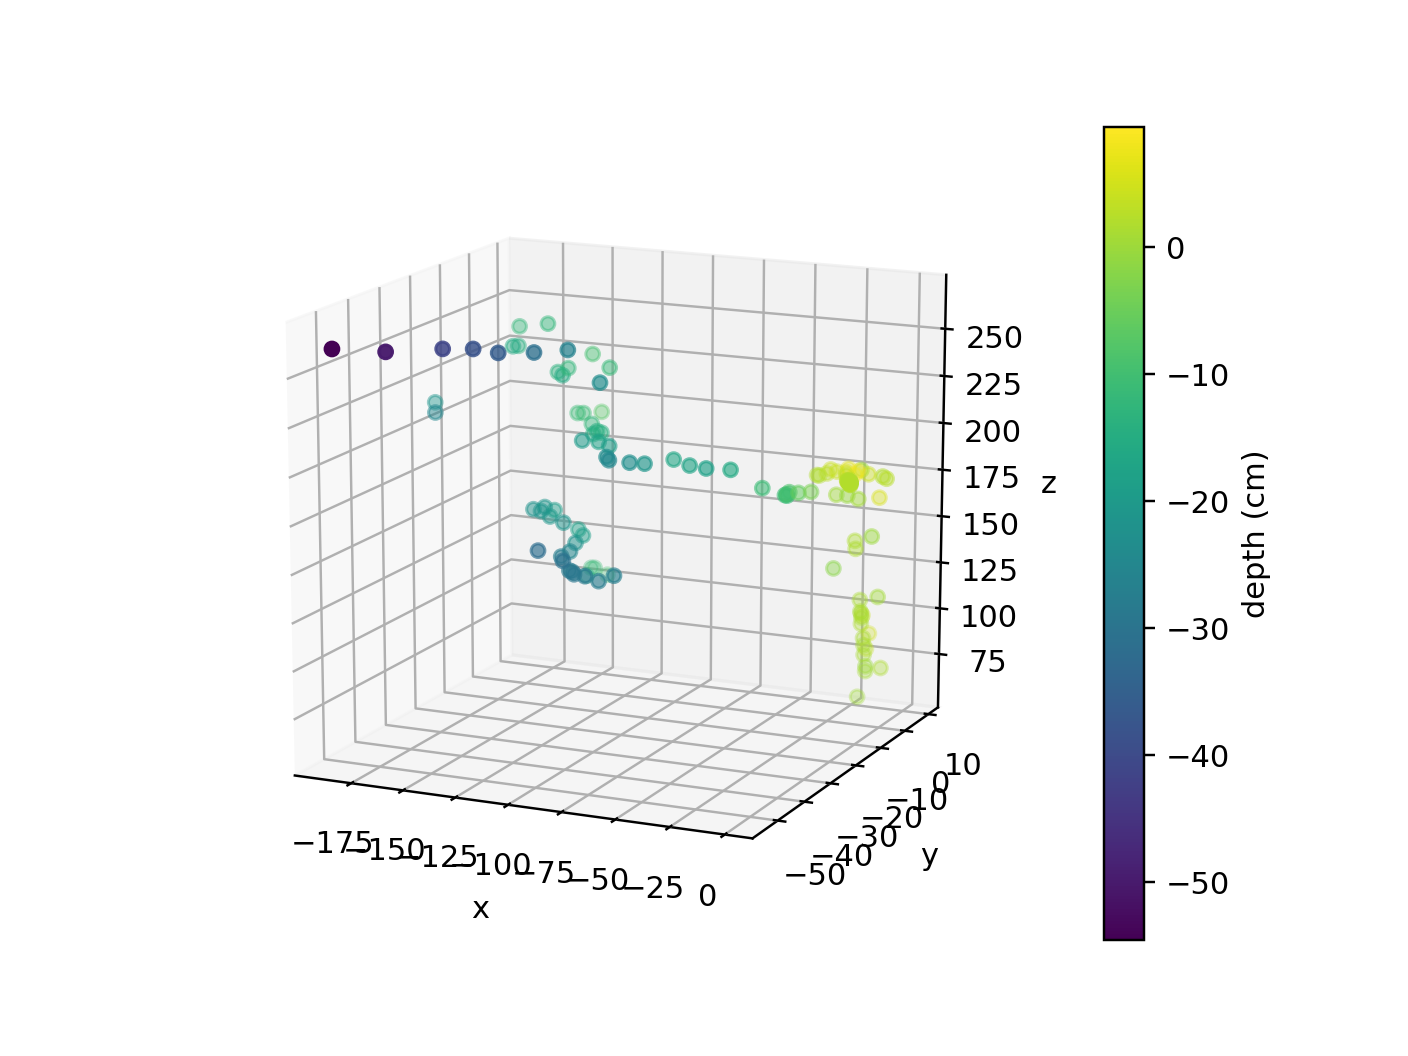

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(df2["x"], df2["y"], df2["z"], c=df2["y"])

# pnt3d=ax.scatter(x,y,z,c=z)

# create colorbar
cbar = plt.colorbar(pnt3d)
cbar.set_label("depth (cm)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()